## MultiVI test

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import os 
from scipy.sparse import csr_matrix
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.metrics import roc_auc_score, average_precision_score
import xchrom as xc

In [3]:
input_path = '../'
save_path = './Results/'

ad_crosscell = sc.read_h5ad(f'{input_path}/1_XChrom/0_model_train/train_data/ad_crosscell.h5ad')  ## cross-cell test label

pred_test = sc.read_h5ad(f'{save_path}/multivi_impute.h5ad')  ## cross-cell test prediction
pred_all = sc.read_h5ad(f'{save_path}/multivi_imp_all.h5ad')  ## all data denoise

rna = sc.read_h5ad(f'{input_path}/0_data/processed_data/m_brain_paired_rna.h5ad') ## provide cell type & X_pca
assert pred_all.obs.index.equals(rna.obs.index), "Indexes differ!"
pred_all.obs['pc32_leiden'] = rna.obs['pc32_leiden']

with h5py.File(f'{input_path}/1_XChrom/0_model_train/train_data/splits.h5', 'r') as hf:
    test_cellid = hf['test_cell'][:]

### test cell auROC&auPRC

In [4]:
m_crosscell_to1 = ad_crosscell.X.copy()  
m_crosscell_to1[m_crosscell_to1 != 0] = 1  # binarize
pred = pred_test.X
true = m_crosscell_to1.toarray()

In [5]:
## -1 Calculate overall auROC & auPRC 
overall_metrics = xc.tl.calc_auc_pr(true, pred, 'overall')
print(f"Overall auROC: {overall_metrics['auroc']:.4f}, auPRC: {overall_metrics['auprc']:.4f}")

## -2 Calculate per cell auRPC & auPRC
cell_metrics = xc.tl.calc_auc_pr(true, pred, 'percell')
print(f"Per-cell auROC: {cell_metrics['auroc']:.4f}, auPRC: {cell_metrics['auprc']:.4f}")
print(f"Valid cells: {cell_metrics['n_cells']}")

## -3 Calculate per peak auROC & auPRC
peak_metrics = xc.tl.calc_auc_pr(true, pred, 'perpeak')
print(f"Per-peak auROC: {peak_metrics['auroc']:.4f}, auPRC: {peak_metrics['auprc']:.4f}")
print(f"Valid peaks: {peak_metrics['n_peaks']}")

Overall auROC: 0.7690, auPRC: 0.3812
Per-cell auROC: 0.7726, auPRC: 0.3684
Valid cells: 487
Per-peak auROC: 0.6439, auPRC: 0.2497
Valid peaks: 36282


### test cell ns&ls

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


neighbor score(100)=0.3941,label score(100)=0.6998
neighbor score(50)=0.3105,label score(50)=0.7432
neighbor score(10)=0.1546,label score(10)=0.8047


<AxesSubplot:title={'center':'pc32_leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

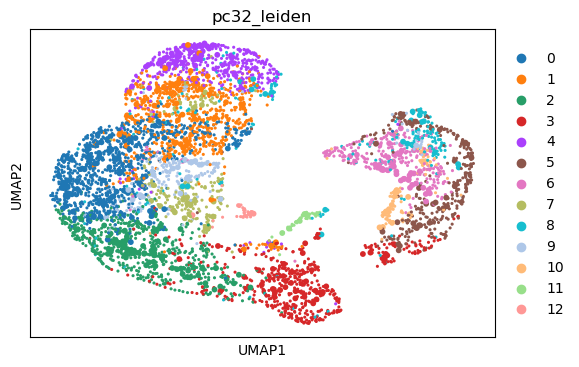

In [6]:
## LS_Lab impute
ad1 = pred_all.copy()
ad1 = xc.tl.calc_pca(ad1)
ns,ls= xc.tl.calc_nsls_score(rna,ad1,100,'pc32_leiden',test_cells =test_cellid,use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(100)={ns:.4f},label score(100)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,50,'pc32_leiden',test_cells =test_cellid,use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(50)={ns:.4f},label score(50)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,10,'pc32_leiden',test_cells =test_cellid,use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(10)={ns:.4f},label score(10)={ls:.4f}')

size_vector = [70 if idx in test_cellid else 20 for idx in range(ad1.n_obs)]
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sc.pl.umap(ad1, color='pc32_leiden', size=size_vector, ax=ax, show=False)